In [3]:
import os
import sys
import json
import glob
import h5py
import tqdm
import time
import numpy as np
import scipy.signal
import scipy.interpolate
import scipy.io
import scipy.io.wavfile
import soundfile as sf
import soxr
import matlab.engine

%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli
import util_misc


In [4]:
eng = matlab.engine.start_matlab();
eng.addpath('HRTFs/');


In [21]:
import importlib
import room_simulator
importlib.reload(room_simulator);


In [17]:
brir = room_simulator.get_brir(
    room_materials=[3] * 6,
    room_dim_xyz=[100, 100, 10],
    head_pos_xyz=[50, 50, 5],
    head_azim=0,
    src_azim=45,
    src_elev=0,
    src_dist=2.8,
    buffer_pos=1,
    sr=44100,
    dur=0.5,
    eng=eng)

brir_near = room_simulator.get_brir(
    room_materials=[3] * 6,
    room_dim_xyz=[100, 100, 10],
    head_pos_xyz=[50, 50, 5],
    head_azim=0,
    src_azim=45,
    src_elev=0,
    src_dist=1.4*3,
    buffer_pos=1,
    sr=44100,
    dur=0.5,
    eng=eng)


Running room simulator: head_pos=[50, 50, 5], src_pos=[51.979898987322336, 51.97989898732233, 5.0], room_dim=[100, 100, 10]
Ran room simulator in 2.5415427684783936 seconds
Running room simulator: head_pos=[50, 50, 5], src_pos=[52.9698484809835, 52.9698484809835, 5.0], room_dim=[100, 100, 10]
Ran room simulator in 1.458587646484375 seconds


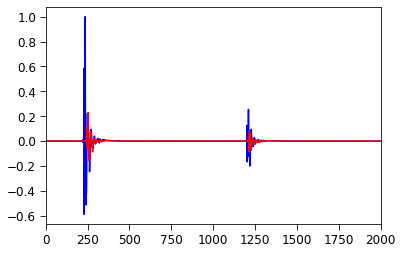

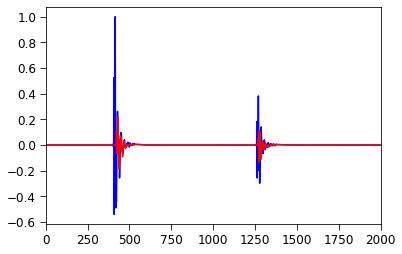

In [11]:
fig, ax = plt.subplots()
ax.plot(brir[:, 0] / brir.max(), 'b')
ax.plot(brir[:, 1] / brir.max(), 'r')
util_figures.format_axes(
    ax,
    xlimits=[0, 2000]
)
plt.show()

fig, ax = plt.subplots()
ax.plot(brir_near[:, 0] / brir_near.max(), 'b')
ax.plot(brir_near[:, 1] / brir_near.max(), 'r')
util_figures.format_axes(
    ax,
    xlimits=[0, 2000]
)
plt.show()


In [142]:
fn = '/om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/background_musdb18hq/000.wav'
y, sr = sf.read(fn)
# y = np.random.randn(*y.shape)
# t = np.arange(0, len(y)) / sr
# y = (np.sin(2 * np.pi * 2 * t) > 0) * y
ipd.display(ipd.Audio(rate=sr, data=y))
print(sr, y.shape)


44100 (132300,)


In [156]:
y_spatial = util_stimuli.spatialize_sound(y, brir)
print(brir.shape, brir.dtype, y_spatial.shape, y_spatial.dtype)
ipd.display(ipd.Audio(rate=sr, data=y_spatial.T, normalize=False))

y_spatial = util_stimuli.spatialize_sound(y, brir_near)
print(brir.shape, brir.dtype, y_spatial.shape, y_spatial.dtype)
ipd.display(ipd.Audio(rate=sr, data=y_spatial.T, normalize=False))


(22050, 2) float64 (132300, 2) float64


(22050, 2) float64 (132300, 2) float64


In [36]:
def sample_room_parameters(
        p_outdoor=0.25,
        range_room_x=[2.8, 56],
        range_room_y=[2.8, 56],
        range_room_z=[2.8, 14],
        list_material_outdoor_floor=[1, 7, 23, 24, 25],
        list_material_outdoor_wall=[1, 2, 3, 4, 5, 6, 7, 23, 24],
        list_material_indoor_floor=[1, 2, 4, 6, 12, 13, 14, 15],
        list_material_indoor_wall=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
        list_material_indoor_ceiling=[3, 6, 16, 17, 18, 19, 20],
        list_n_unique_wall_materials=[1, 2, 3, 4],
        p_outdoor_wall=0.25):
    """
    """
    ANECHOIC = 26
    is_outdoor = np.random.choice([1, 0], p=[p_outdoor, 1-p_outdoor])
    x_len = np.exp(np.random.uniform(low=np.log(range_room_x[0]), high=np.log(range_room_x[1]), size=None))
    y_len = np.exp(np.random.uniform(low=np.log(range_room_y[0]), high=np.log(range_room_y[1]), size=None))
    z_len = np.exp(np.random.uniform(low=np.log(range_room_z[0]), high=np.log(range_room_z[1]), size=None))
    if is_outdoor:
        material_floor = np.random.choice(list_material_outdoor_floor)
        material_ceiling = np.random.choice([ANECHOIC])
        material_wall = np.random.choice(
            [-1, ANECHOIC],
            size=4,
            replace=True,
            p=[p_outdoor_wall, 1-p_outdoor_wall])
        IDX_outdoor_wall = material_wall < 0
        material_wall[IDX_outdoor_wall] = np.random.choice(
            list_material_outdoor_wall,
            size=IDX_outdoor_wall.sum(),
            replace=True)
    else:
        material_floor = np.random.choice(list_material_indoor_floor)
        material_ceiling = np.random.choice(list_material_indoor_ceiling)
        n_unique_wall_materials = np.random.choice(list_n_unique_wall_materials)
        material_wall = np.random.choice(
            list_material_indoor_wall,
            size=n_unique_wall_materials,
            replace=False)
        if len(material_wall < 4):
            material_wall = np.concatenate([
                material_wall,
                np.random.choice(material_wall, size=4-len(material_wall), replace=True),
            ])
    room_parameters = {
        'room_materials': list(material_wall) + [material_floor, material_ceiling],
        'room_dim_xyz': [x_len, y_len, z_len],
        'is_outdoor': is_outdoor,
        'material_wall_xmin': room_simulator.map_int_to_material[material_wall[0]],
        'material_wall_xmax': room_simulator.map_int_to_material[material_wall[1]],
        'material_wall_ymin': room_simulator.map_int_to_material[material_wall[2]],
        'material_wall_ymax': room_simulator.map_int_to_material[material_wall[3]],
        'material_floor': room_simulator.map_int_to_material[material_floor],
        'material_ceiling': room_simulator.map_int_to_material[material_ceiling],
    }
    print(f"Sampled room")
    for k in room_parameters.keys():
        print(f"|__ {k}: {room_parameters[k]}")
    return room_parameters


for _ in range(20):
    sample_room_parameters()


Sampled room
|__ room_materials: [4, 6, 2, 5, 2, 18]
|__ room_dim_xyz: [8.139455016148563, 30.40824247756773, 3.816320629120369]
|__ is_outdoor: 0
|__ material_wall_xmin: Marble
|__ material_wall_xmax: Plywood
|__ material_wall_ymin: Concrete, painted
|__ material_wall_ymax: Plaster on Concrete
|__ material_floor: Concrete, painted
|__ material_ceiling: Acoustic tiles, 0.5", 16" below ceiling
Sampled room
|__ room_materials: [10, 4, 11, 10, 15, 6]
|__ room_dim_xyz: [15.473728973797531, 5.770620096318525, 13.223626807719125]
|__ is_outdoor: 0
|__ material_wall_xmin: Fiberglass wall treatment, 7 in
|__ material_wall_xmax: Marble
|__ material_wall_ymin: Wood panelling on glass fiber blanket
|__ material_wall_ymax: Fiberglass wall treatment, 7 in
|__ material_floor: Carpet on foam rubber padding
|__ material_ceiling: Plywood
Sampled room
|__ room_materials: [3, 26, 26, 26, 25, 26]
|__ room_dim_xyz: [39.493453623478715, 11.882016579278844, 11.028069712179475]
|__ is_outdoor: 1
|__ material_

In [30]:
x = np.array([1, 2, 3])
if len(x < 6):
    x = np.concatenate([x, np.random.choice(x, size=6-len(x), replace=True)])
x

array([1, 2, 3, 2, 1, 2])

In [137]:
eng.quit()
